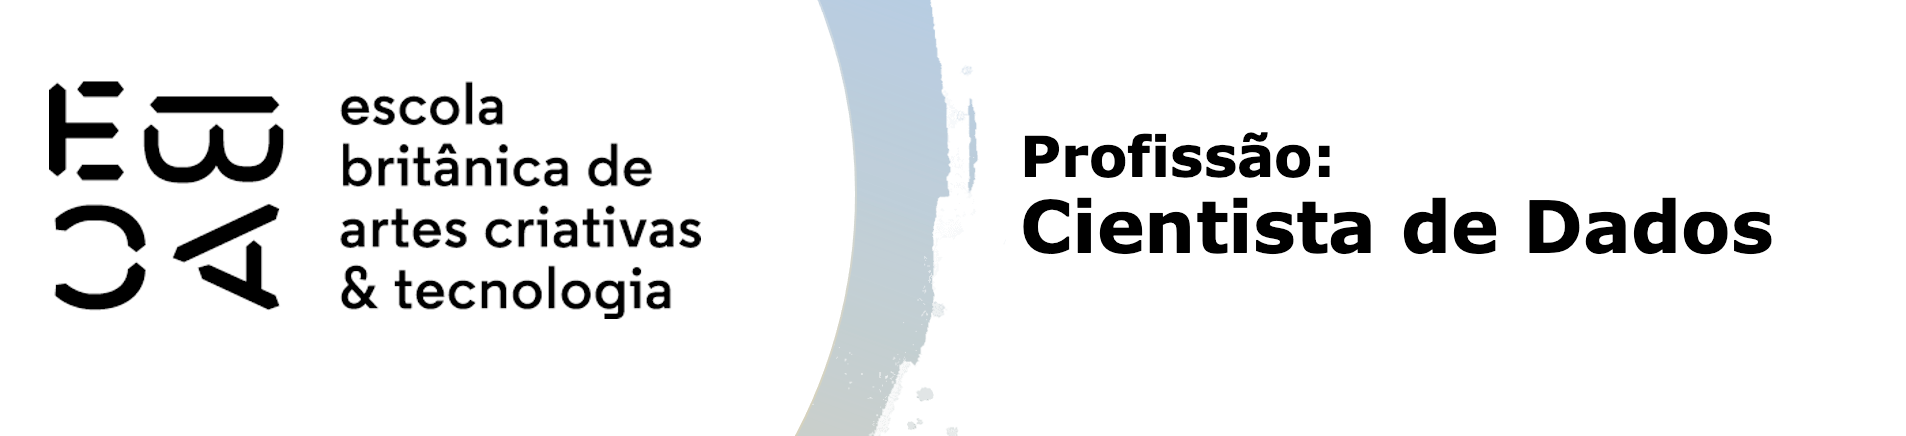

# Tarefa - Agrupamento hierárquico

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo agora é agrupar as sessões de acesso ao portal considerando o comportamento de acesso e informações da data, como a proximidade a uma data especial, fim de semana e o mês.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from gower import gower_matrix 
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist, squareform

from sklearn.preprocessing import StandardScaler


In [109]:
df = pd.read_csv('../online_shoppers_intention.csv')
df = df.drop(columns = ['OperatingSystems', 'Browser'])
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,1,4,Returning_Visitor,True,False


In [110]:
df.Revenue.value_counts(dropna=False)

Revenue
False    10422
True      1908
Name: count, dtype: int64

## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  Region                   12330 non-null  int64  
 12  TrafficType              12330 non-null  int64  
 13  VisitorType              12330 non-null  object 
 14  Weekend               

In [112]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,9.000000,20.000000


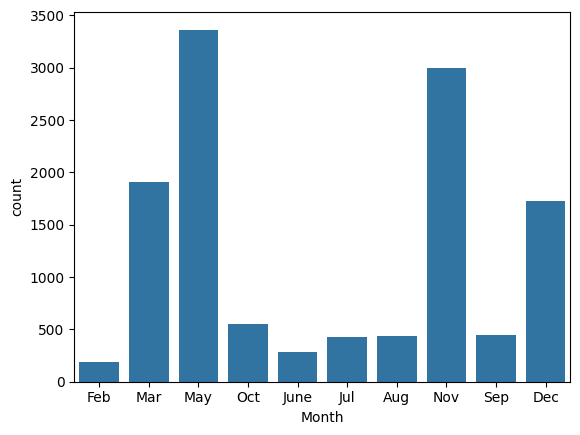

In [113]:
# countplot Month:

sns.countplot(x = df.Month);

# podemos observar que as maiores quantidades de acessos estão nos meses de maio e novembro;

<Axes: xlabel='Month', ylabel='count'>

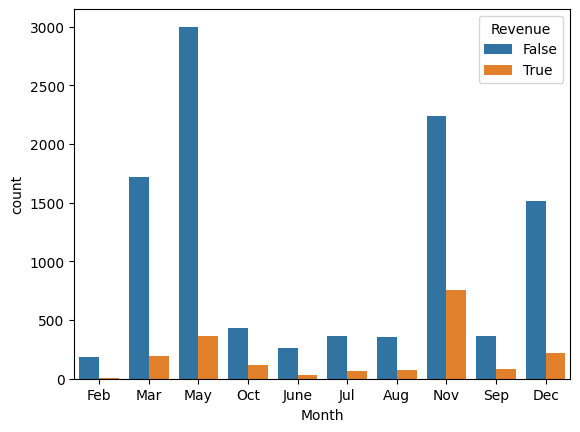

In [114]:
# countplot Month x Revenue:

sns.countplot(df, x = df.Month, hue = df.Revenue)

# podemos notar um aumento significativo em quantidade de visitas e de compras efetuadas nos meses May e Nov, 
# com um aumento significativo na proporção qtd visitas x compras no mês de novembro. Proximidade com a BlackFriday?

Percentual de transações efetuadas: 15.47%


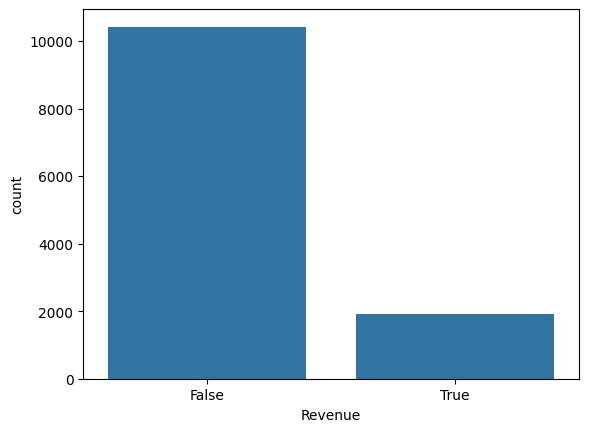

In [115]:
# countplot da distribuição de Revenue:

sns.countplot(x = df.Revenue);
print(f'Percentual de transações efetuadas: {(df.Revenue.sum()/df.shape[0]*100):.2f}%')



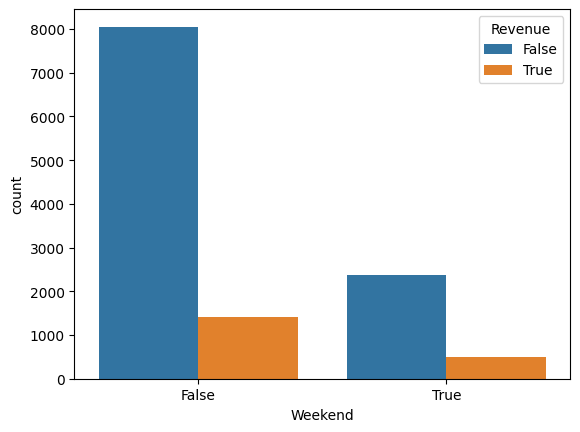

In [116]:
# countplot Weekend discriminado por Revenue:

sns.countplot(df, x = df.Weekend, hue = df.Revenue);

# nota-se que tanto a quantidade de acessos quanto a quantidade de transações efetuadas é maior durante a semana em comparação a fins de semana.

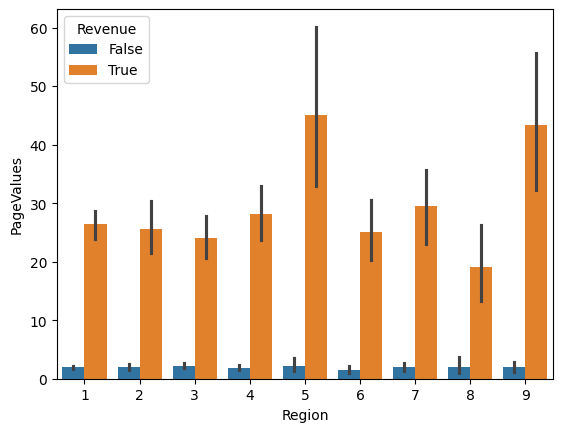

In [117]:
# barplot PageValues x Region por vendas (Revenue):

sns.barplot(y = df.PageValues, x = df.Region, hue = df.Revenue);

# Podemos notar que as regiões 5 e 9 tem uma maior média de valor de páginas visitadas antes de concluir uma transação;

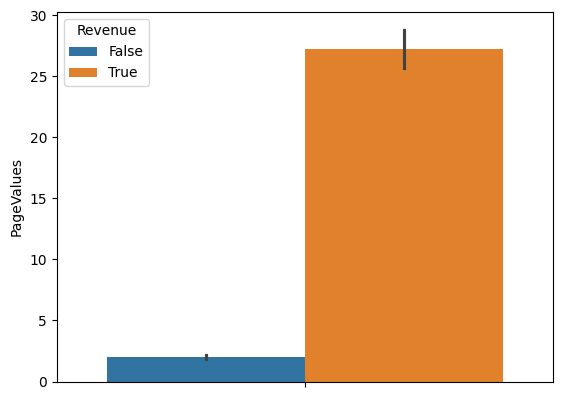

In [118]:
# barplot PageValues com compras efetuadas vs não efetuadas:

sns.barplot(y = df.PageValues, hue = df.Revenue);

# podemos notar que a média de compras efetuadas está acima de $ 25.00, e de compras não efetuadas abaixo de $ 3. 

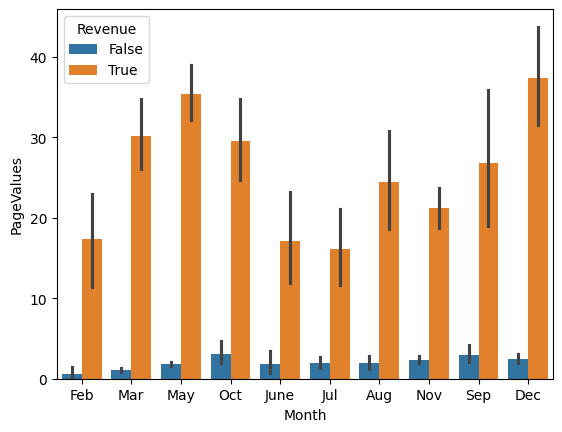

In [119]:
# barplot Month x PageValues descrito por Revenue:

sns.barplot( x = df.Month, y = df.PageValues, hue = df.Revenue);

# notamos aqui que Mar, May, Oct e Dez possuem as maiores médias em valor $ em transações concluídas;

In [120]:
# avaliando os dados através da matriz de correlação:

corr_matrix = df.select_dtypes(include=['int', 'float', 'bool']).drop(columns = ['Region', 'TrafficType']).corr()
corr_matrix

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Weekend,Revenue
Administrative,1.000000,0.601583,0.376850,0.255848,0.431119,0.373939,-0.223563,-0.316483,0.098990,-0.094778,0.026417,0.138917
Administrative_Duration,0.601583,1.000000,0.302710,0.238031,0.289087,0.355422,-0.144170,-0.205798,0.067608,-0.073304,0.014990,0.093587
Informational,0.376850,0.302710,1.000000,0.618955,0.374164,0.387505,-0.116114,-0.163666,0.048632,-0.048219,0.035785,0.095200
Informational_Duration,0.255848,0.238031,0.618955,1.000000,0.280046,0.347364,-0.074067,-0.105276,0.030861,-0.030577,0.024078,0.070345
ProductRelated,0.431119,0.289087,0.374164,0.280046,1.000000,0.860927,-0.204578,-0.292526,0.056282,-0.023958,0.016092,0.158538
ProductRelated_Duration,0.373939,0.355422,0.387505,0.347364,0.860927,1.000000,-0.184541,-0.251984,0.052823,-0.036380,0.007311,0.152373
BounceRates,-0.223563,-0.144170,-0.116114,-0.074067,-0.204578,-0.184541,1.000000,0.913004,-0.119386,0.072702,-0.046514,-0.150673
ExitRates,-0.316483,-0.205798,-0.163666,-0.105276,-0.292526,-0.251984,0.913004,1.000000,-0.174498,0.102242,-0.062587,-0.207071
PageValues,0.098990,0.067608,0.048632,0.030861,0.056282,0.052823,-0.119386,-0.174498,1.000000,-0.063541,0.012002,0.492569
SpecialDay,-0.094778,-0.073304,-0.048219,-0.030577,-0.023958,-0.036380,0.072702,0.102242,-0.063541,1.000000,-0.016767,-0.082305


In [121]:
positive_corr = corr_matrix.where(corr_matrix > 0.49)
positive_corr

# notamos correlações positivas entre os seguintes grupos de variáveis: A:(Administrative, Administrative_Duration), 
# B:(Informational, Informational_Duration), C:(ProductRelated, ProductRelated_Duration), D:(BounceRates, ExitRates) e E:(PageValues, Revenue),
# com destaque para os grupos C e D, que obtiveram correlação acima de 85%.

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Weekend,Revenue
Administrative,1.000000,0.601583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Administrative_Duration,0.601583,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Informational,NaN,NaN,1.000000,0.618955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Informational_Duration,NaN,NaN,0.618955,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProductRelated,NaN,NaN,NaN,NaN,1.000000,0.860927,NaN,NaN,NaN,NaN,NaN,NaN
ProductRelated_Duration,NaN,NaN,NaN,NaN,0.860927,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
BounceRates,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.913004,NaN,NaN,NaN,NaN
ExitRates,NaN,NaN,NaN,NaN,NaN,NaN,0.913004,1.000000,NaN,NaN,NaN,NaN
PageValues,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.492569
SpecialDay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


In [122]:
negative_corr = corr_matrix.where(corr_matrix < -0.49)
negative_corr

# não há correlações negativas significativas entre os dados.

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Weekend,Revenue
Administrative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Administrative_Duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Informational,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Informational_Duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProductRelated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProductRelated_Duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BounceRates,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ExitRates,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PageValues,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SpecialDay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Variáveis de agrupamento

Liste as variáveis que você vai querer utilizar. Essa é uma atividade importante do projeto, e tipicamente não a recebemos pronta. Não há resposta pronta ou correta, mas apenas critérios e a sua decisão. Os critérios são os seguintes:

- Selecione para o agrupamento variáveis que descrevam o padrão de navegação na sessão.
- Selecione variáveis que indiquem a característica da data.
- Não se esqueça de que você vai precisar realizar um tratamento especial para variáveis qualitativas.
- Trate adequadamente valores faltantes.

In [123]:
# var_escopo = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  Region                   12330 non-null  int64  
 12  TrafficType              12330 non-null  int64  
 13  VisitorType              12330 non-null  object 
 14  Weekend               

In [124]:
df.loc[:, 'TrafficType'] = df['TrafficType'].astype(str)
df.loc[:, 'Region'] = df['Region'].astype(str)
df.loc[:, 'SpecialDay'] = df['SpecialDay'].astype(str)

C:\Users\alext\AppData\Local\Temp\ipykernel_16112\1242983212.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1' '2' '3' ... '13' '11' '2']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, 'TrafficType'] = df['TrafficType'].astype(str)
C:\Users\alext\AppData\Local\Temp\ipykernel_16112\1242983212.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1' '1' '9' ... '1' '3' '1']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, 'Region'] = df['Region'].astype(str)
C:\Users\alext\AppData\Local\Temp\ipykernel_16112\1242983212.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['0.0' '0.0' '0.0' ... '0.0' '0.0' '0.0']' has dtype incompatible with float64, please explicitly c

In [125]:
# definindo as variaveis quantitativas:

variaveis = df.columns

variaveis_quant = variaveis.drop(['Month', 'Region', 'TrafficType', 'VisitorType', 'Weekend', 'Revenue'])
df[variaveis_quant].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  object 
dtypes: float64(6), int64(3), object(1)
memory usage: 963.4+ KB


In [126]:
variaveis

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'Region', 'TrafficType', 'VisitorType', 'Weekend', 'Revenue'],
      dtype='object')

In [127]:
# definindo as variaveis qualitativas:

variaveis_cat = variaveis[-7:]
variaveis_cat

Index(['SpecialDay', 'Month', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')

In [128]:
# definindo as variaveis relacionadas a data:

variaveis_data = variaveis[9:15]
variaveis_data = variaveis_data.drop(['Region', 'TrafficType', 'VisitorType'])

In [129]:
# padronizando as variaveis quantitativas:

df_pad = pd.DataFrame(StandardScaler().fit_transform(df[variaveis_quant]), columns = df[variaveis_quant].columns)

In [130]:
# atribuindo o conteúdo do dataframe original no dataframe padronizado:

df_pad[variaveis_cat] = df[variaveis_cat]
# df_pad[variaveis_data] = df[variaveis_data]

In [131]:
# definindo as dummies:

df2 = pd.get_dummies(df_pad[variaveis])
df2.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,Weekend,...,TrafficType_3,TrafficType_4,TrafficType_5,TrafficType_6,TrafficType_7,TrafficType_8,TrafficType_9,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,False,...,False,False,False,False,False,False,False,False,False,True
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,-0.457683,1.171473,-0.317178,False,...,False,False,False,False,False,False,False,False,False,True
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,False,...,True,False,False,False,False,False,False,False,False,True
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,0.573535,1.994610,-0.317178,False,...,False,True,False,False,False,False,False,False,False,True
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,-0.045196,0.142551,-0.317178,True,...,False,True,False,False,False,False,False,False,False,True


In [132]:
df2.columns.values

array(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated',
       'ProductRelated_Duration', 'BounceRates', 'ExitRates',
       'PageValues', 'Weekend', 'Revenue', 'SpecialDay_0.0',
       'SpecialDay_0.2', 'SpecialDay_0.4', 'SpecialDay_0.6',
       'SpecialDay_0.8', 'SpecialDay_1.0', 'Month_Aug', 'Month_Dec',
       'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May',
       'Month_Nov', 'Month_Oct', 'Month_Sep', 'Region_1', 'Region_2',
       'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7',
       'Region_8', 'Region_9', 'TrafficType_1', 'TrafficType_10',
       'TrafficType_11', 'TrafficType_12', 'TrafficType_13',
       'TrafficType_14', 'TrafficType_15', 'TrafficType_16',
       'TrafficType_17', 'TrafficType_18', 'TrafficType_19',
       'TrafficType_2', 'TrafficType_20', 'TrafficType_3',
       'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7',
       'TrafficType_8', 'TrafficTy

In [133]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 59 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Administrative                 12330 non-null  float64
 1   Administrative_Duration        12330 non-null  float64
 2   Informational                  12330 non-null  float64
 3   Informational_Duration         12330 non-null  float64
 4   ProductRelated                 12330 non-null  float64
 5   ProductRelated_Duration        12330 non-null  float64
 6   BounceRates                    12330 non-null  float64
 7   ExitRates                      12330 non-null  float64
 8   PageValues                     12330 non-null  float64
 9   Weekend                        12330 non-null  bool   
 10  Revenue                        12330 non-null  bool   
 11  SpecialDay_0.0                 12330 non-null  bool   
 12  SpecialDay_0.2                 12330 non-null 

In [134]:
# marcando os vetores:

vetor_cat = [True if x in {'Month_Aug',
       'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar',
       'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'Region_1',
       'Region_2', 'Region_3', 'Region_4', 'Region_5', 'Region_6',
       'Region_7', 'Region_8', 'Region_9', 'TrafficType_1',
       'TrafficType_10', 'TrafficType_11', 'TrafficType_12',
       'TrafficType_13', 'TrafficType_14', 'TrafficType_15',
       'TrafficType_16', 'TrafficType_17', 'TrafficType_18',
       'TrafficType_19', 'TrafficType_2', 'TrafficType_20',
       'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6',
       'TrafficType_7', 'TrafficType_8', 'TrafficType_9',
       'VisitorType_New_Visitor', 'VisitorType_Other',
       'VisitorType_Returning_Visitor'} else False for x in df2.columns]

vetor_cat

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [135]:
# calculando as distancias:

distancia_gower = gower_matrix(df2, cat_features = vetor_cat)

In [136]:
distancia_gower[:5, :5]

array([[0.        , 0.05936303, 0.06779661, 0.08561797, 0.07919618],
       [0.05936303, 0.        , 0.09326134, 0.07543998, 0.05712128],
       [0.06779661, 0.09326134, 0.        , 0.08561797, 0.11309449],
       [0.08561797, 0.07543998, 0.08561797, 0.        , 0.06137482],
       [0.07919618, 0.05712128, 0.11309449, 0.06137482, 0.        ]],
      dtype=float32)

In [137]:
# utilizando o squareform para colocar a matriz de distâncias no formato necessário para o algoritmo:

gdv = squareform(distancia_gower,force='tovector')

In [138]:
gdv.shape

(76008285,)

## Número de grupos

Nesta atividade vamos adotar uma abordagem bem pragmática e avaliar agrupamentos hierárquicos com 3 e 4 grupos, por estarem bem alinhados com uma expectativa e estratégia do diretor da empresa. 

*Atenção*: Cuidado se quiser fazer o dendrograma, pois com muitas observações ele pode ser mais complicado de fazer, e dependendo de como for o comando, ele pode travar o *kernell* do seu python.

In [139]:
# treinando o agrupamento:

Z = linkage(gdv, method='complete')
Z_df = pd.DataFrame(Z,columns=['id1','id2','dist','n'])
Z_df.head()

,id1,id2,dist,n
0,0.0,182.0,0.0,2.0
1,16.0,64.0,0.0,2.0
2,85.0,158.0,0.0,2.0
3,125.0,132.0,0.0,2.0
4,159.0,12333.0,0.0,3.0


In [141]:
# marcando os grupos na tabela original com 4 clusters e fazendo uma rápida inspeção para identificar os grupos:

df2['grupos_4'] = fcluster(Z, 4, criterion='maxclust')
df2.grupos_4.value_counts()

grupos_4
4    8526
3    1520
1    1431
2     853
Name: count, dtype: int64

In [142]:
# marcando os grupos na tabela original com 3 clusters e fazendo uma rápida inspeção para identificar os grupos:

df2['grupos_3'] = fcluster(Z, 3, criterion='maxclust')
df2.grupos_3.value_counts()

grupos_3
3    10046
1     1431
2      853
Name: count, dtype: int64

In [143]:
# fazendo um left join da base original com a base df2 fazendo um merge pelo index:

df3 = df.reset_index().merge(df2.reset_index(), how='left')

C:\Users\alext\AppData\Local\Temp\ipykernel_16112\1622464645.py:3: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df3 = df.reset_index().merge(df2.reset_index(), how='left')


In [144]:
df3 = df.join(df2['grupos_3'], how='left').join(df2['grupos_4'], how='left')

In [145]:
# substitundo os rótulos da coluna grupo_3:

df3['grupos_3'] = df3['grupos_3'].replace({1:"grupo_1", 3:"grupo_3", 2:"grupo_2"})

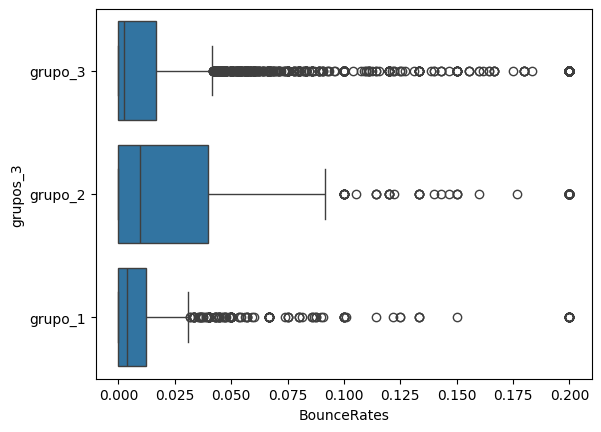

In [146]:
# verificando variação de dados entre as colunas grupo_3 e BounceRates

sns.boxplot(data = df3, y = 'grupos_3', x = 'BounceRates');

In [148]:
# crosstab entre as colunas Revenue e grupo_3:

pd.crosstab(df3.Revenue, df3.grupos_3)

grupos_3,grupo_1,grupo_2,grupo_3
Revenue,,,
False,1154,820,8448
True,277,33,1598


In [149]:
# substitundo os rótulos da coluna grupo_4:

df3['grupos_4'] = df3['grupos_4'].replace({1:"grupo_1", 3:"grupo_3", 2:"grupo_2", 4:'grupo_4'})

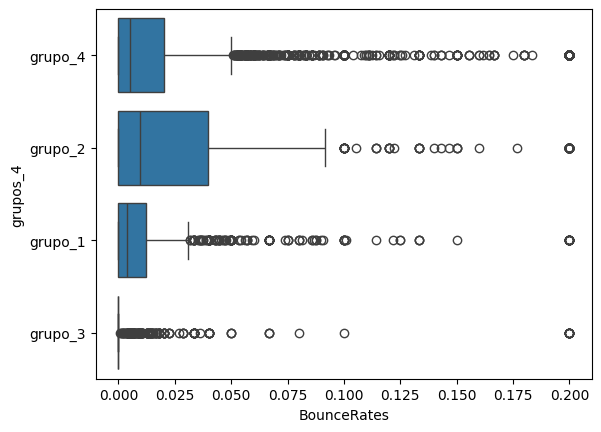

In [150]:
# verificando variação de dados entre as colunas grupo_4 e BounceRates

sns.boxplot(data = df3, y = 'grupos_4', x = 'BounceRates');

In [151]:
# crosstab entre as colunas Revenue e grupos_4:

pd.crosstab(df3.Revenue, df3.grupos_4)

grupos_4,grupo_1,grupo_2,grupo_3,grupo_4
Revenue,,,,
False,1154,820,1150,7298
True,277,33,370,1228


## Avaliação dos grupos

Construa os agrupamentos com a técnica adequada que vimos em aula. Não se esqueça de tratar variáveis qualitativas, padronizar escalas das quantitativas, tratar valores faltantes e utilizar a distância correta.

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.

In [152]:
# construindo solução de agrupamento com 2 grupos:

df2['grupos_2'] = fcluster(Z, 2, criterion='maxclust')
df2.grupos_2.value_counts()

grupos_2
2    10899
1     1431
Name: count, dtype: int64

In [153]:
# fazendo um left join com a base original e substituindo os rótulos:

df3 = df.join(df2['grupos_2'], how='left')
df3['grupos_2'] = df3['grupos_2'].replace({1:"grupo_1", 2:"grupo_2"})

C:\Users\alext\AppData\Local\Temp\ipykernel_16112\1371891098.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df3, y='grupos_2', x='BounceRates', palette = 'Paired');


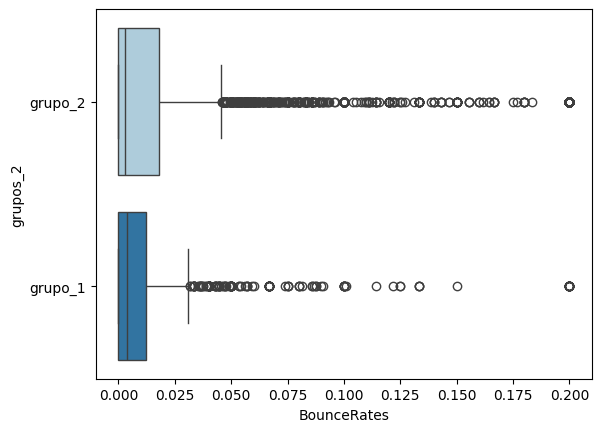

In [154]:
# verificando variação de dados entre as colunas grupos_2 e BounceRates:

sns.boxplot(data=df3, y='grupos_2', x='BounceRates', palette = 'Paired');

In [155]:
# crosstab entre as colunas Revenue e grupos_2:

pd.crosstab(df3.Revenue, df3.grupos_2)

grupos_2,grupo_1,grupo_2
Revenue,,
False,1154,9268
True,277,1631


In [156]:
# construindo solução de agrupamento com 5 grupos:

df2['grupos_5'] = fcluster(Z, 5, criterion='maxclust')
df2.grupos_5.value_counts()

grupos_5
5    7772
3    1520
1    1431
2     853
4     754
Name: count, dtype: int64

In [157]:
# fazendo um left join com a base original e substituindo os rótulos:

df3 = df.join(df2['grupos_5'], how='left')
df3['grupos_5'] = df3['grupos_5'].replace({1:"grupo_1", 2:"grupo_2", 3:'grupo_3', 4:'grupo_4', 5:'grupo_5'})

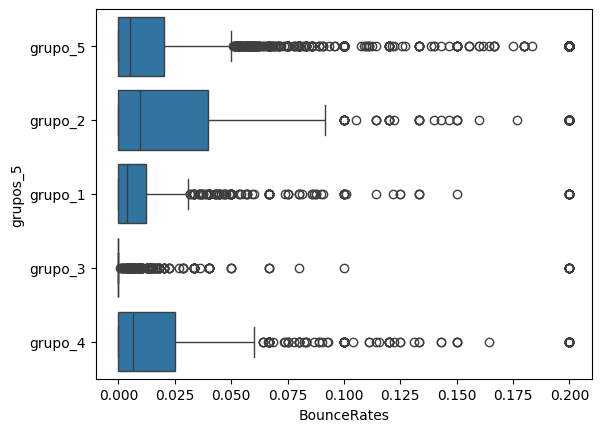

In [158]:
# verificando variação de dados entre as colunas grupos_5 e BounceRates:

sns.boxplot(data=df3, y='grupos_5', x='BounceRates');

In [159]:
# crosstab entre as colunas Revenue e grupos_5:

pd.crosstab(df3.Revenue, df3.grupos_5)

grupos_5,grupo_1,grupo_2,grupo_3,grupo_4,grupo_5
Revenue,,,,,
False,1154,820,1150,663,6635
True,277,33,370,91,1137


 - Os agrupamentos com 2 e 3 grupos possuíram uma melhor distribuição dos dados;

 - Os agrupamentos com 4 e 5 grupos parecem se quebrar em pequenos grupos, com poucos dados e muitos outliers, o que prejudica a análise;

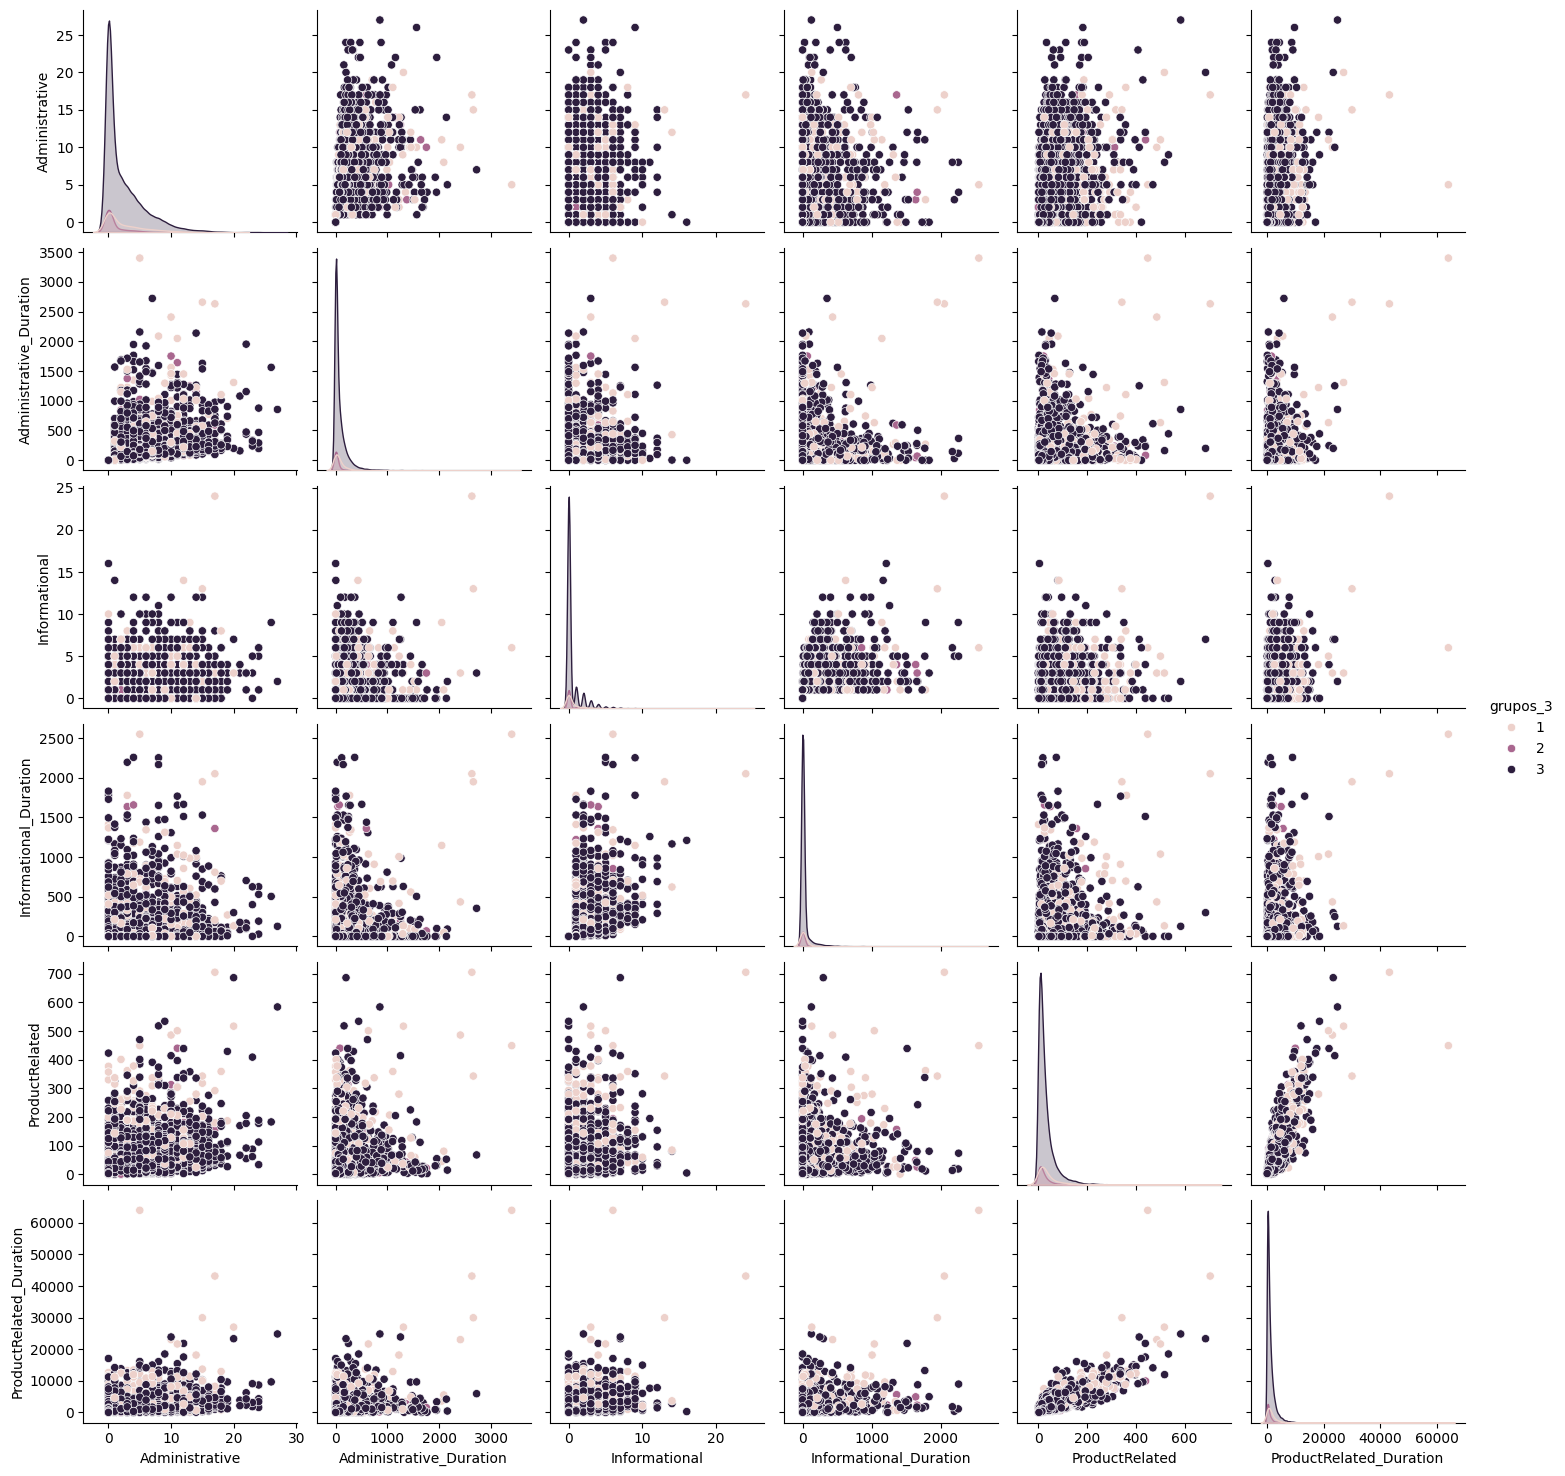

In [177]:
# escolhendo o agrupamento final com 3 grupos, levando em consideração a escolha do presidente da empresa e fazendo um pairplot da relação entre as variáveis:

df2['grupos_3'] = fcluster(Z, 3, criterion='maxclust')

# Pegando a base original e fazendo um left join 

df3 = df.join(df2['grupos_3'], how='left')

# Substitundo os rótulos da coluna

df3['grupos_3'].replace({1:"grupo_1", 3:"grupo_3", 2:"grupo_2"})


sns.pairplot(df3[['Administrative', 'Administrative_Duration', 'Informational', 
                  'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 
                  'grupos_3']], hue='grupos_3');

In [178]:
# crosstab entre colunas Revenue e grupos_3 normalizando os valores pela soma das colunas :

pd.crosstab(df3.Revenue, df3.grupos_3, normalize='columns')

# notamos que o percentual de compra do grupo 1 é de quase 20%

grupos_3,1,2,3
Revenue,,,
False,0.806429,0.961313,0.840932
True,0.193571,0.038687,0.159068


<Axes: xlabel='Weekend', ylabel='count'>

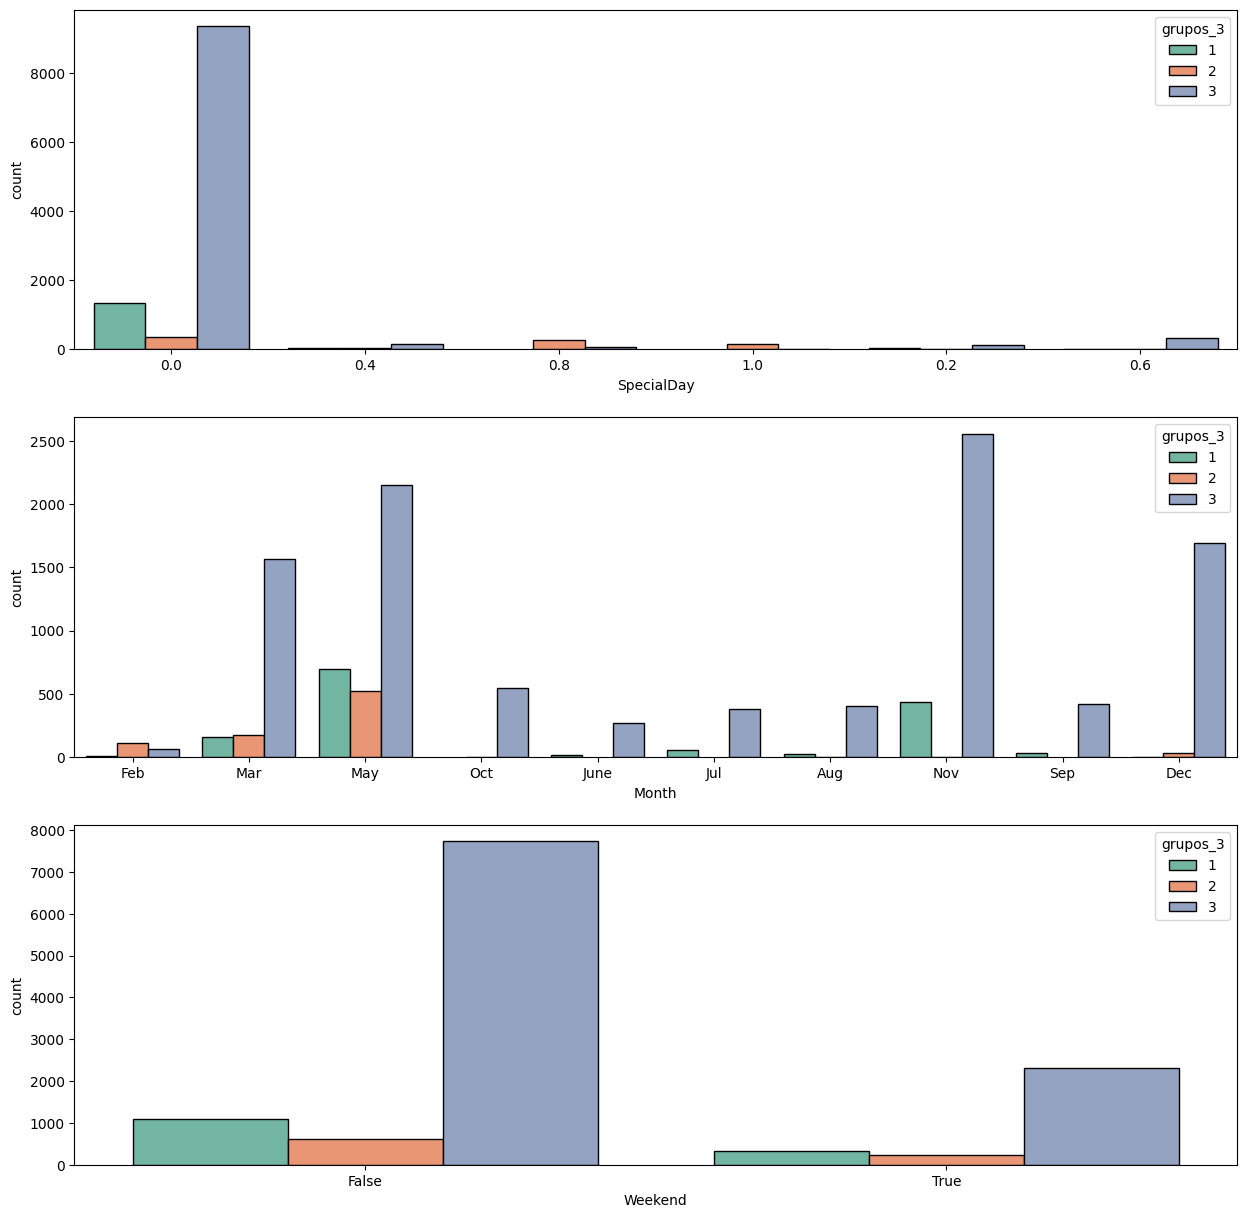

In [179]:
# distribuição das variáveis
fig, axis = plt.subplots(3, 1, figsize=(15,15))

sns.countplot(data = df3, x = "SpecialDay", hue = df3.grupos_3, palette ='Set2', edgecolor='black', ax=axis[0])
sns.countplot(data = df3, x = "Month", hue = df3.grupos_3, palette ='Set2', edgecolor='black', ax=axis[1])
sns.countplot(data = df3, x = "Weekend", hue = df3.grupos_3, palette ='Set2', edgecolor='black', ax=axis[2])

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

 - Notamos na análise descritiva que o grupo 3 é o segundo maior grupo em percentual nos quesitos BounceRates e Revenue, onde tem as menores taxas de BounceRates e a maiores taxas de Revenue;

 - Notamos também que o grupo 1 tem uma maior proporção de compras por fim de semana em relação às compras totais, mas pode configurar um grupo de 'nicho'. Porém o grupo 3 o supera bastante em volume de compras totais em comparação aos outros grupos, o que o torna mais interessante quando falamos de volumes de compras, atingindo mais pessoas em uma possível campanha.